# Tensorflow LTR Example Notebook

This notebook demonstrates the usage of tfltr and gives some information on extending the model and how to get optimal performance.

In [1]:
import os
import numpy as np
import sklearn.datasets
import sklearn.model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# LTR model and auxiliary functions
from model import LTRModel
import utils

In [2]:
# Test to see if Tensorflow finds the GPU
device_name = tf.test.gpu_device_name()
if not device_name:
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Preparing the data

For this demo I use the Scikit-learn diabetes dataset, since it is well suited for high-dimensional nonlinear regression.

In [3]:
diabetes_bunch = sklearn.datasets.load_diabetes(as_frame=True)

I check the type of the data and visualize the distribution of the target variable.

In [4]:
data_df = diabetes_bunch.data
target_df = diabetes_bunch.target

full_df = pd.concat([data_df, data_df], axis=1)

full_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


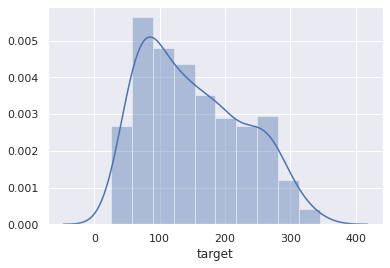

In [5]:
sns.set()
sns.set_context('notebook')
sns.distplot(target_df)
plt.show()

### Reshaping and normalizing

The model takes inputs as numpy arrays or Tensorflow tensors

In [6]:
X = data_df.values
y = target_df.values

print(f"X shape is : {X.shape}\ny shape is: {y.shape}")

X shape is : (442, 10)
y shape is: (442,)


Many of the model parameters are quite sensitive to the magnitude of the data and target, so for consistent results both the data and target should be normalized to zero mean and unit variance.

In [7]:
X = (X - np.mean(X, axis=0)) / np.sqrt(np.var(X, axis=0))
y = (y - np.mean(y)) / np.sqrt(np.var(y))

y = np.reshape(y, (-1, 1))

### Splitting to training and test sets

In [8]:
train_idx, test_idx = sklearn.model_selection.train_test_split(np.arange(X.shape[0]))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

## Training the model

Next we train the model on this data. The LTRModel class takes the following arguments:
* __order__ - the order of the polynomial
* __rank__ - rank of the tensor rank decomposition of the weigth tensor
* __multirank__ - how many ranks to train at once, default is all
* __nepochs__ - number of epochs the model is trained
* __batch_size__ - size of mini-batches, can be in the order of 1000
* __regularization_factor__ - the regularization factor as described in the original LTR paper
* __loss_fn__ - loss function, should be a Tensorflow function for optimal performance
* __show_progress__ - whether to show the tqdm progress bar
* __logging__ - whether to perform logging for Tensorboard
* __rank_step__ - how many ranks to move forward after training, default is the same number as multirank
* __sparse__ - whether data is in a sparse format, will be inferred if not defined

For this demonstration I use a model of order 3 and rank 10, and the Tensorflow implementation of the Adam optimizer with learning rate 0.01 and otherwise default parameters.

In [9]:
model = LTRModel(order=3,
                 rank=10,
                 nepochs=500,
                 optimizer=tf.keras.optimizers.Adam(0.01),
                 regularization_factor=1e-9,
                 logging=True,
                 show_progress=True)

In [10]:
model.fit(X_train, y_train, X_test, y_test,
          run_name=f'diabetes_test')

  0%|          | 0/500 [00:00<?, ?epoch/s]

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


100%|██████████| 500/500 [00:08<00:00, 61.62epoch/s]


In [11]:
test_predictions = model.predict_numpy(X_test)

utils.performance_indicators(test_predictions, y_test, "LTR_test")

{'rmse': 0.8037058413178749,
 'r2': -3.9957618851668526,
 'pearson': 0.41891489855068836,
 'spearman': 0.47669946718569894}

The `get_summaries` function can be used to fetch the Tensorboard summaries.

In [13]:
summaries = utils.get_summaries("./logs")

diabetes_summary = summaries[0]

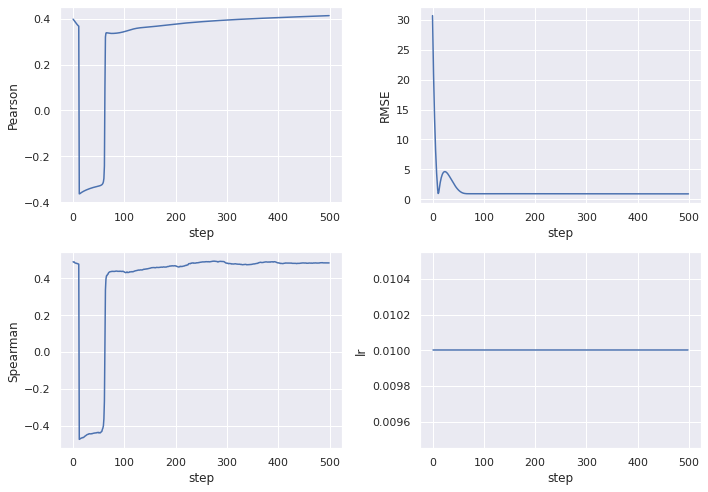

In [14]:
sns.set()
sns.set_context('notebook')

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharey=False)

sns.lineplot(x='step',y='Pearson', data=diabetes_summary, ax=axes[0, 0])
sns.lineplot(x='step',y='RMSE', data=diabetes_summary, ax=axes[0, 1])
sns.lineplot(x='step',y='Spearman', data=diabetes_summary, ax=axes[1, 0])
sns.lineplot(x='step',y='lr', data=diabetes_summary, ax=axes[1, 1])

plt.tight_layout()

## Notes about performance

Training with GPU can give a significant performance boost compared to training using CPU. In my tests there was more than a 50% speedup. Implementing a custom gradient function however did not provide much of a performance improvement, although this might also be due to computational bottlenecks elsewhere. 
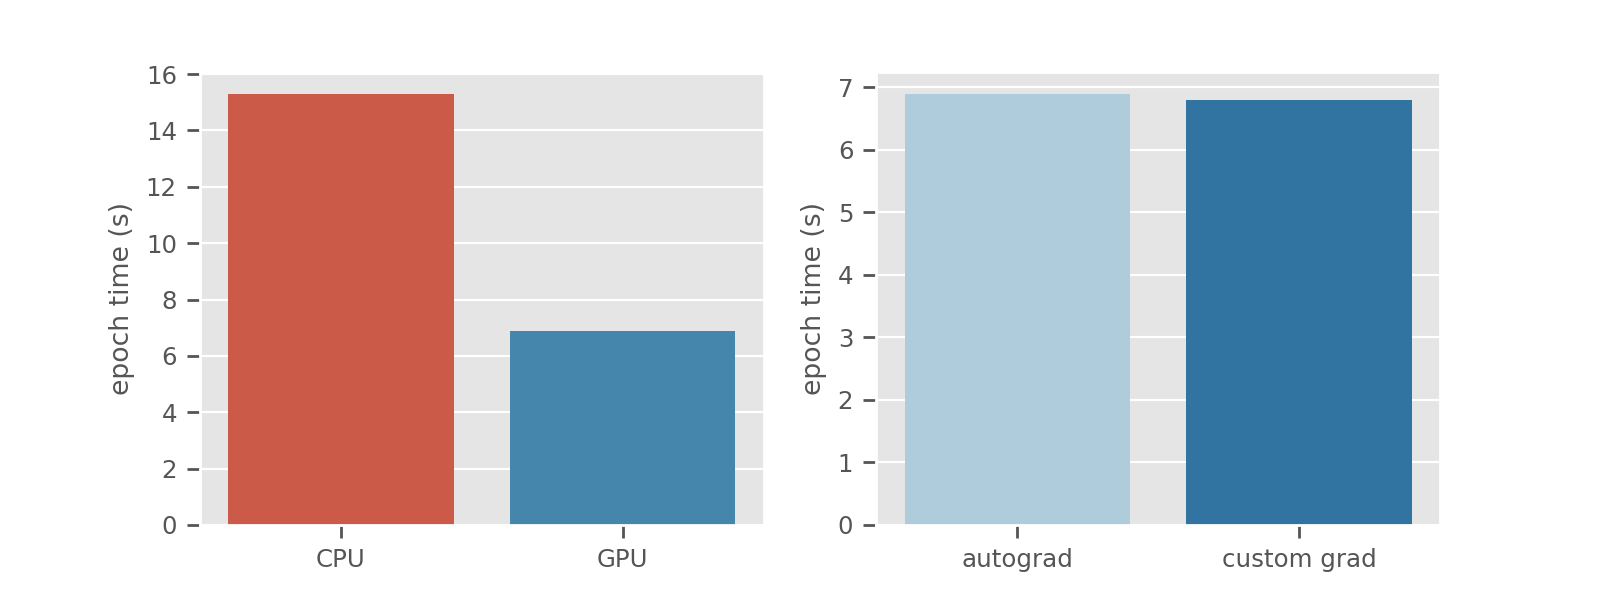

From both a theoretical and practical standpoint it is generally better to train all ranks simultaneously. The figure below shows experimental results of training rank-wise vs. all ranks simultanously on a synthetic dataset of rank 4.
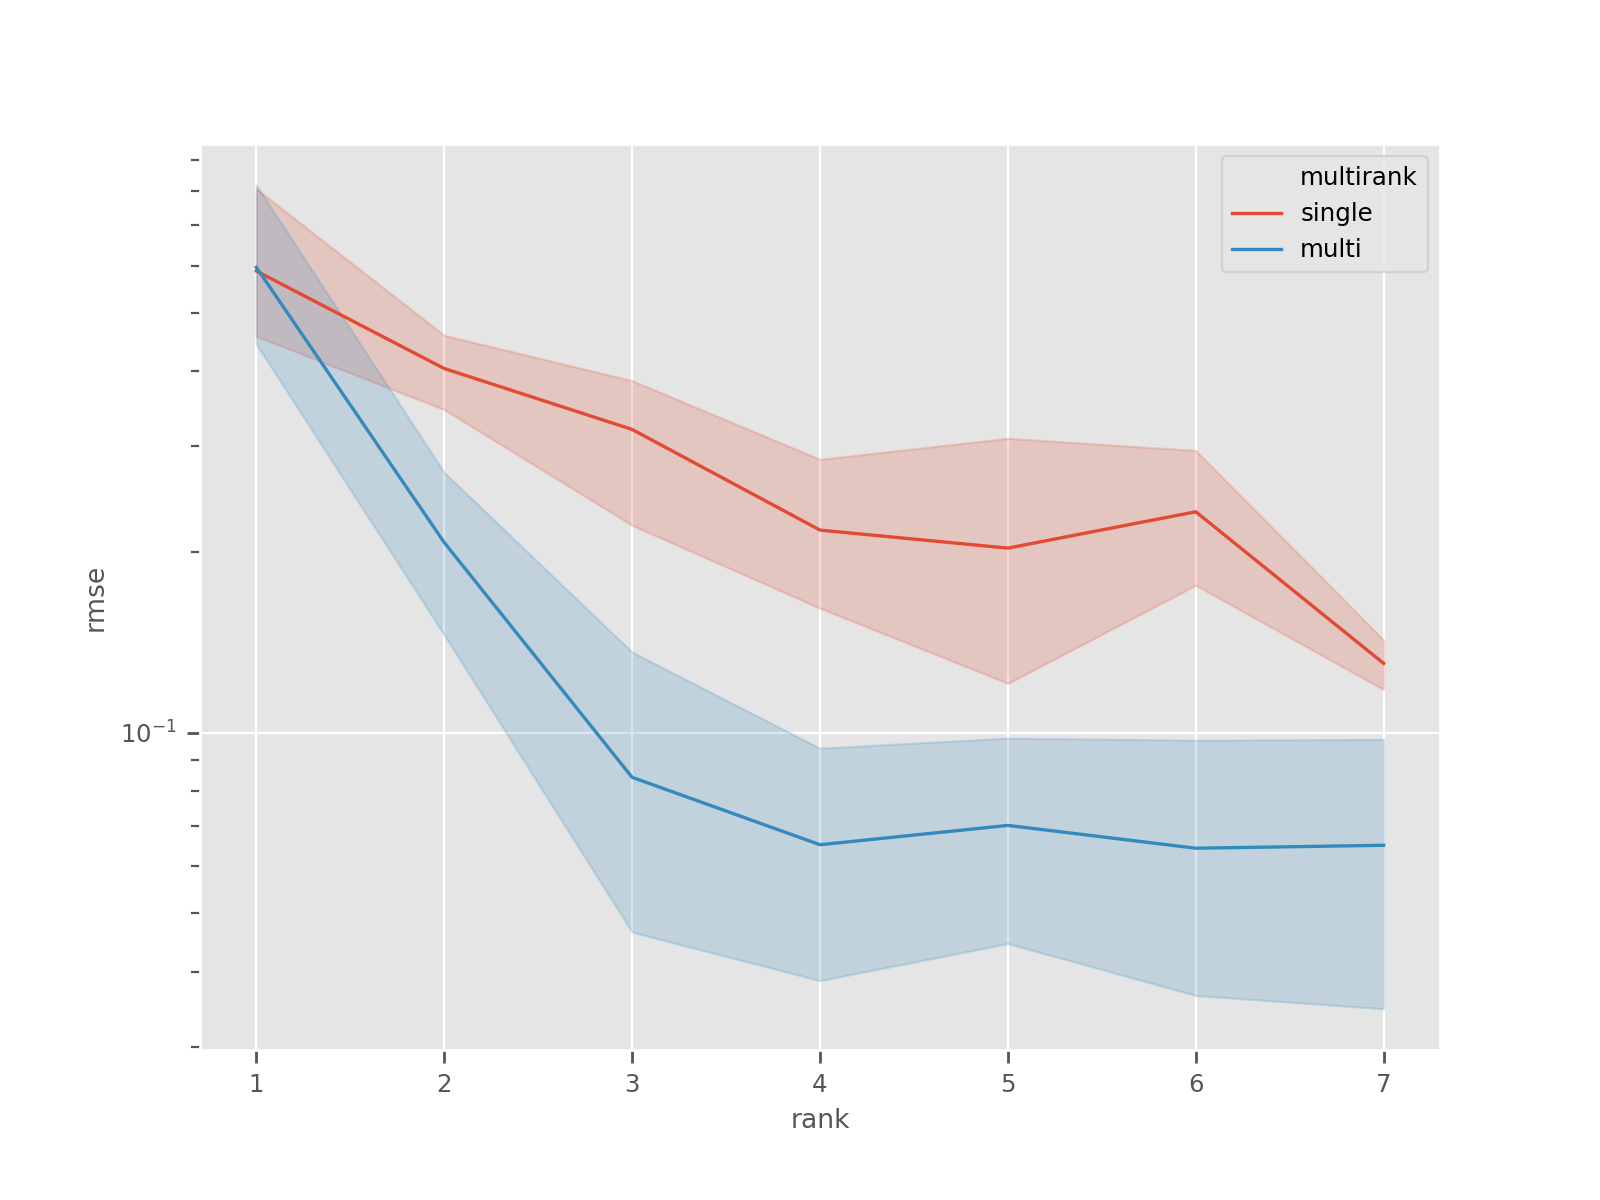

The advantage as also noted by Szedmak et al. is that if we only train part of the ranks, we achieve a lower memory cost, since not all model parameters need to be held in memory simultaneously. The downside particularly with my implementation, is that we need to create a copy of target that gets 'deflated' when moving to the next rank, which requires extra computations.